# **Introduction**

This notebook is for implementing an Actor-Critic method based on the advantage function (A2C), for learning an optimal policy for the `Cartpole` environment. The Actor-Critic method utilizes two networks, one of which is responsible for mapping states to a probability distribution over the actions (actor), and another which estimates the value of a state to guide the actor (critic). The general idea is that the actor updates its policy in the direction suggested by the critic.

Also, as per [this paper](https://proceedings.mlr.press/v97/ahmed19a/ahmed19a.pdf), I am also implementing entropy regularization in an attempt to reduce variance and improve performance. Similarly, I am vectorizing the environment, employing the use of `n_envs` concurrent environments, such that the implemented algorithm is more akin to [its original introduction](https://arxiv.org/pdf/1602.01783).

# **Import Packages**

This section imports the necessary packages.

In [141]:
# import these:
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
from wrappers.swingup_wrapper import SwingUpWrapper
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# **Environment Setup**

This section sets up the environment and defines the relevant functions needed for this implementation.

##### Function for making vectorized environments:

In [142]:
# function that takes seed and env_name:
def make_env(env_name : str, seed, wrapped : bool = False ):
    # does not work without this, for some reason:
    def intermediary():
        # make the environment based on the provided env_name:
        env = gym.make(env_name)

        # wrap environment:
        if wrapped:
            env = SwingUpWrapper(env)

        # reset and seed the environment:
        env.reset(seed = seed)

        # return env to user:
        return env
    return intermediary

##### Function for making Keras models:

In [143]:
# function for making a keras model based on user inputs:
def make_model(layers, neurons, rate, input_shape, output_shape, loss_function, output_activation):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f"hidden_layer_{i+1}"))
        else: 
            model.add(Dense(neurons, activation = 'relu', name = f"hidden_layer_{i+1}"))

    # add output layer:
    model.add(Dense(output_shape, activation = output_activation, name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    # return to user:
    return model

##### Vectorized A2C class:

In [144]:
# A2C class:
class A2C_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self,
                envs: gym.Env,
                gamma: float, 
                lr_a: float,
                lr_c: float, 
                beta: float,
                layers = int, 
                neurons = int,
                n_envs = int,
                n_steps: int = 5):
        """
        this is the constructor for the agent. this agent uses the advantage actor-critic (A2C) algorithm to learn an optimal policy,
        through the use of two approximator networks. the first network, called the actor, is responsible for providing the probabilty 
        distribution over all actions given a state. the second network, called the critic, is responsible for utilizing the advantage function
        to guide the learning of the actor.

        this implementation uses entropy regularization to encourage exploration, and utilizes a vectorized environment to increase the stabilizing
        effect on the training procedure.

        envs:               asynchronously vectorized gymnasium environments
        gamma:              a float value indicating the discount factor, γ
        lr_a:               a float value indicating the learning rate of the actor, α_a
        lr_c:               a float value indicating the learning rate of the critic, α_c
        beta:               a float value indicating the entropy regularization parameter, β
        layers:             an int value indicating the number of layers in a network
        neurons:            an int value indicating the number of neurons per layer
        n_steps:            an int value indicating the number of steps to use when computing the return
        n_envs:             an int value indicating the number of parallel environments used

        nS:                 an int representing the number of states observed, each of which is continuous
        nA:                 an int representing the number of discrete actions that can be taken

        actor:              a Keras sequential neural network representing the actor
        critic:             a Keras sequential neural network representing the actor

        buf_states:         a list used to hold the states used in the n-step return
        buf_actions:        a list used to hold the actions used in the n-step return
        buf_rewards:        a list used to hold the rewards used in the n-step return
        buf_next_states:    a list used to hold the next states used in the n-step return
        buf_next_dones:     a list used to hold the dones used in the n-step return
        
        """
        # object parameters:
        self.envs       = envs
        self.gamma      = gamma
        self.lr_a       = lr_a
        self.lr_c       = lr_c
        self.beta       = beta
        self.n_steps    = n_steps
        self.n_envs     = n_envs

        # get environment dimensions:
        self.nS = envs.single_observation_space.shape[0]
        self.nA = envs.single_action_space.n

        # initialize the networks:
        self.actor = make_model(layers = layers,
                                neurons = neurons,
                                rate = lr_a,
                                input_shape = self.nS,
                                output_shape = self.nA,
                                output_activation = "softmax",
                                loss_function = "categorical_crossentropy")

        self.critic = make_model(layers = layers,
                                neurons = neurons,
                                rate = lr_c,
                                input_shape = self.nS,
                                output_shape = 1,
                                output_activation = "linear",
                                loss_function = "mse")

        # initialize buffers for rollout:
        self.obs_buf = []
        self.act_buf = []
        self.rew_buf = []
        self.val_buf = []
        self.done_buf = []

    ####################### TRAINING #######################
    # function for calculating discounted returns:
    def discounted_returns(self, rewards, dones, last_value):
        # compute the discounted cumulative reward for a vectorized environment:
        returns = np.zeros((self.n_steps, self.n_envs))
        running_return = last_value

        # start computing discounted return:
        for t in reversed(range(self.n_steps)):
            running_return = rewards[t] + self.gamma * running_return * (1 - dones[t])
            returns[t] = running_return
    
        # return to user:
        return returns

    # decorated training step function:
    @tf.function
    def training_step(self, states, actions, returns, advantages):
        # convert values to tensors, if not already:
        states = tf.convert_to_tensor(states, dtype = tf.float32)
        actions = tf.cast(actions, dtype = tf.int32)
        returns = tf.cast(returns, dtype = tf.float32)
        advantages = tf.cast(advantages, dtype = tf.float32)

        # CRITIC UPDATE:
        with tf.GradientTape() as critic_tape:
            # pass state through critic:
            values = tf.squeeze(self.critic(states, training = True), axis = 1)

            # compute critic loss:
            critic_loss = tf.reduce_mean(tf.square(returns - values))

        # backpropagate and update critic:
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        # ACTOR UPDATE:
        with tf.GradientTape() as actor_tape:
            # pass state through actor to get probabilites:
            probabilities = self.actor(states, training = True)

            # take a log of policy for scoring:
            log_probs = tf.math.log(tf.clip_by_value(probabilities, 1e-8, 1.0))

            # get a mask of the actions chosen:
            action_mask = tf.one_hot(actions, self.nA, dtype = tf.float32)

            # get the log probabilities of the actions that were actually chosen:
            log_probs_chosen = tf.reduce_sum(action_mask * log_probs, axis = 1)

            # entropy term:
            entropy_per_sample = -tf.reduce_sum(probabilities * log_probs, axis = 1)

            # compute the actor loss (ascent):
            actor_loss = -tf.reduce_mean(log_probs_chosen * advantages) - self.beta * tf.reduce_mean(entropy_per_sample)

        # backpropagate and update actor:
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))

    # gymnasium training function:
    def train(self, num_updates, train_metrics):
        # 0) initialization:
        per_env_reward = np.zeros(self.n_envs)
        reward_history = []

        obs, _ = self.envs.reset()

        # for an update:
        for update in tqdm(range(num_updates), colour = "#33FF00", ncols = 100, desc = "training progress:"):
            # 1) reset rollout buffers:
            self.obs_buf = []
            self.act_buf = []
            self.rew_buf = []
            self.val_buf = []
            self.done_buf = []

            # 2) rollout for n_steps:
            for step in range(self.n_steps):
                # a) pass observations through networks:
                obs_tensor = tf.convert_to_tensor(obs, dtype = tf.float32)
                actor_output = self.actor(obs_tensor)
                critic_output = self.critic(obs_tensor)

                # b) pick an action:
                probs = actor_output.numpy()
                probs /= probs.sum(axis = 1, keepdims = True)       # normalize to remove floating point error
                actions = [np.random.choice(len(prob), p = prob) for prob in probs] 

                # c) step the environments:
                next_obs, rewards, terms, truncs, _ = self.envs.step(actions)
                per_env_reward += rewards
                done = np.logical_or(terms, truncs)

                # d) record finished episodes, clear reward for those envs:
                finished_indexes = np.where(done)[0]
                for i in finished_indexes:
                    # append the per_env_reward of that env to history:
                    reward_history.append(per_env_reward[i])
                    per_env_reward[i] = 0.0

                # e) pass transtions into buffers:
                self.obs_buf.append(obs.copy())
                self.act_buf.append(actions.copy())
                self.rew_buf.append(rewards.copy())
                self.val_buf.append(critic_output.numpy().squeeze())
                self.done_buf.append(done.copy())

                # f) advance the observation:
                # vectorized environments auto-reset their sub-envs, so its either next obs or the reset obs
                obs = next_obs.astype(np.float32)

            # 3) check for completion:
            if len(reward_history) >= train_metrics["min_train"]:
                # compute a recent average:
                recent_average = np.mean(reward_history[-train_metrics["over_last"]:]).round(3)

                # if the recent average is above the desired threshold:
                if recent_average >= train_metrics["desired_score"]:
                    print(f"environment solved in {len(reward_history)} episodes!")
                    print(f"average reward was: {recent_average}")

                    # save weights:
                    os.makedirs(train_metrics["model_path"], exist_ok = True)
                    try:
                        # paths:
                        actor_path = f"{train_metrics["model_path"]}/actor_weights.weights.h5"
                        critic_path = f"{train_metrics["model_path"]}/critic_weights.weights.h5"

                        # save weights:
                        self.actor.save_weights(actor_path)
                        self.critic.save_weights(critic_path)
                        print("model saved!")
                    except Exception as e:
                        print(f"failed to save model: {e}")
                    break

            # 4) bootstrap value handling:
            last_values = self.critic(tf.convert_to_tensor(obs, dtype = tf.float32)).numpy().squeeze()
            last_done = self.done_buf[-1]       # boolean array from the last step of the rollout
            last_values[last_done] = 0.0        # set to zero for bootstrapping envs that are terminated

            # 5) stack buffers:
            self.obs_buf = np.array(self.obs_buf)
            self.act_buf = np.array(self.act_buf)
            self.rew_buf = np.array(self.rew_buf)
            self.val_buf = np.array(self.val_buf)
            self.done_buf = np.array(self.done_buf)

            # 6) compute returns and advantages:
            returns = self.discounted_returns(self.rew_buf, self.done_buf, last_values)
            advantages = returns - self.val_buf

            # 7) flatten buffers, merging across steps and envs:
            flat_obs = self.obs_buf.reshape(-1, self.nS)
            flat_act = self.act_buf.reshape(-1)
            flat_ret = returns.reshape(-1)
            flat_adv = advantages.reshape(-1)

            # 8) normalize the advantage:
            flat_adv = (flat_adv - flat_adv.mean()) / (flat_adv.std() + 1e-8)

            # 9) update step:
            self.training_step(flat_obs, flat_act, flat_ret, flat_adv)

        # 10) return to user:
        return reward_history

# **Using the Environment**

This section utilizes the above implementation to create an environment and train an agent.

##### Specify hyperparameters:

In [145]:
# agent hyperparameters:
lr_a = 1e-4
lr_c = 1e-3
gamma = 0.99
beta = 1e-1
layers = 3
neurons = 64
n_steps = 5

# environmental hyperparameters:
num_updates = 10000
n_envs = 16

# parameters for training:
desired_score = 490
over_last = 250
min_train = 1000

base_path = os.path.join(os.getcwd(), "weights")
model_path = os.path.join(base_path, f"cartpole_{len(os.listdir(base_path)) + 1}")

train_metrics = {"desired_score"    : desired_score,
                 "over_last"        : over_last,
                 "min_train"        : min_train,
                 "model_path"       : model_path}

##### Initialize the environments and the agent:

In [146]:
# create the environments:
envs = AsyncVectorEnv([make_env(env_name = "CartPole-v1", wrapped = False, seed = i) for i in range(n_envs)])

# clear the backend:
tf.keras.backend.clear_session()

# make the agent:
agent = A2C_Agent(envs = envs, 
                  gamma = gamma, 
                  lr_a = lr_a, 
                  lr_c = lr_c, 
                  beta = beta, 
                  layers = layers, 
                  neurons = neurons, 
                  n_envs = n_envs, 
                  n_steps = n_steps)

##### Train the agent:

In [147]:
# training:
reward_history = agent.train(num_updates = num_updates, train_metrics = train_metrics)

training progress::  29%|███████████▏                          | 2949/10000 [02:17<05:29, 21.37it/s]

environment solved in 1921 episodes!
average reward was: 490.36
model saved!


##### Plotting the results:

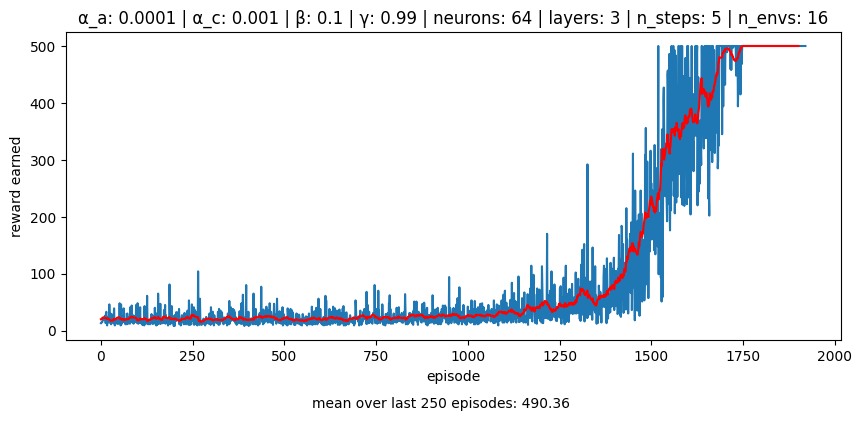

In [148]:
# moving average function:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'valid')

filtered_data = moving_average(reward_history, 20)
last_few = np.mean(reward_history[-over_last:]).round(3)

figure = plt.figure(figsize = (10, 4))
plt.plot(reward_history)
plt.plot(filtered_data, 'r-')
plt.minorticks_on
plt.title(f"α_a: {lr_a} | α_c: {lr_c} | β: {beta} | γ: {gamma} | neurons: {neurons} | layers: {layers} | n_steps: {n_steps} | n_envs: {n_envs}")
plt.xlabel('episode')
plt.ylabel(f'reward earned')
plt.figtext(x = 0.5, y = -0.05, s = f"mean over last {over_last} episodes: {last_few}", ha = 'center', va = 'center')

# save figure:
if len(model_path) != 0:
    try:
        plt.savefig(f"{model_path}/reward_episode_plot.png", bbox_inches = "tight")
    except:
        pass

# **Visualization**

This section visualizes the performance of the model using `render_mode = human`.

In [149]:
visualize = True

if visualize:
    # prepare the new environment:
    env = gym.make("CartPole-v1", render_mode = 'human', max_episode_steps = 500)

    # wrap:
    # env = SwingUpWrapper(env)

    # give the agent the new environment:
    agent.envs = env

    # prep the visualization:
    obs, _ = agent.envs.reset()
    done = False

    # while false:
    while not done:
        # start rendering the environment:
        agent.envs.render()

        # pick an action from the actor network output:
        obs_tensor = tf.convert_to_tensor(obs[None, :], dtype = tf.float32)
        probs = agent.actor(obs_tensor, training = False)
        action = np.random.choice(len(probs[0]), p = probs.numpy()[0])

        # take the action on the environment:
        next_obs, reward, term, trunc, _ = agent.envs.step(action)
        print(f"reward was: {reward}", end = "\r")

        # advance state:
        obs = next_obs

        # check the completion status:
        done = term or trunc

    env.close()